# Transformations
In the final part of this lesson, we will discuss variables transformations. These can be applied either to the outcome variable or to the predictors and can be used for a variety of reasons. Often, transformations are employed so that the model fits better or to correct for violations of certain assumptions. Other times, transformations can be used to help the interpretation of the model, or can be used to add functions of existing predictors to make the fit more flexible. In this part of the lesson, we will discuss methods of transformation for all these purposes.

## Transforming the Outcome
Typically, transformations applied to the outcome variable concern the model fit, but can also be used to improve the assumptions given that any transformation applied to the outcome will be carried into a transformation of the residuals. 

It is important that we constrain the types of transformations we apply to the data. Typically, we only want to consider transformations that are *monotonic*. This means that the order of the data is preserved. One example would be taking $\log y_{i}$, as the data will remain in the same order. However, an example of a *non-monotonic* transformation would be the absolute value $|y_{i}|$ because if there are *negative* values of $y$ they will be made *positive* and the data order will change. A similar situation happens with negative values and $y^{2}$.

### Box-Cox Transformations
Given that there are a wide variety of possible transformations, we could simply guess and try lots of different transformations to see what happens. However, a more principled method was given by [Box & Cox (1964)](http://www.econ.illinois.edu/~econ508/Papers/boxcox64.pdf). Here, transformations of the form $y^{\lambda}_{i}$ are considered. When $\lambda \neq 0$ this is a simple power transformation and when $\lambda = 0$ then this is defined as $\log y_{i}$. This then encompasses a wide-range of possible transformations. For instance, $\lambda = \frac{1}{2}$ would lead to $y^\frac{1}{2}_{i} = \sqrt{y_{i}}$, $\lambda = -1$ would lead to $y^{-1} = \frac{1}{y_{i}}$ and $\lambda = 1$ would lead to $y^{1}_{i} = y_{i}$, indicating that no transformation is needed. 

The utility of this method is that the value of $\lambda$ that makes the data most probable can be found using maximum likelihood. This means that rather than searching through lots of possible transformations, we can just run the Box-Cox method and then evaluate whether a transform seems necessary. Of note, however, is that

- Box-Cox is only defined for $y_{i} > 0$. If your data has negative or 0 values, it will need to first be offset by adding a constant to make all values greater than 0.
- The value of $\lambda$ returned can be anything, which can make the transformed data hard to interpret. If the returned value is close to a more intepretable transformation, you may wish to choose that instead. For instance, if $\hat{\lambda} = 0.46$, you may just wish to use $\hat{\lambda} = 0.5$, which is then equivalent to a square-root transformation.
- Box-Cox is sensitive to outliers, so if you get very large estimated values of $\lambda$ (such as $\hat{\lambda} = 5$), then this is likely the reason. Extreme transformations are almost never warranted.

As an example, we can use the `boxcox()` function from the `MASS` package on our model of `mpg`

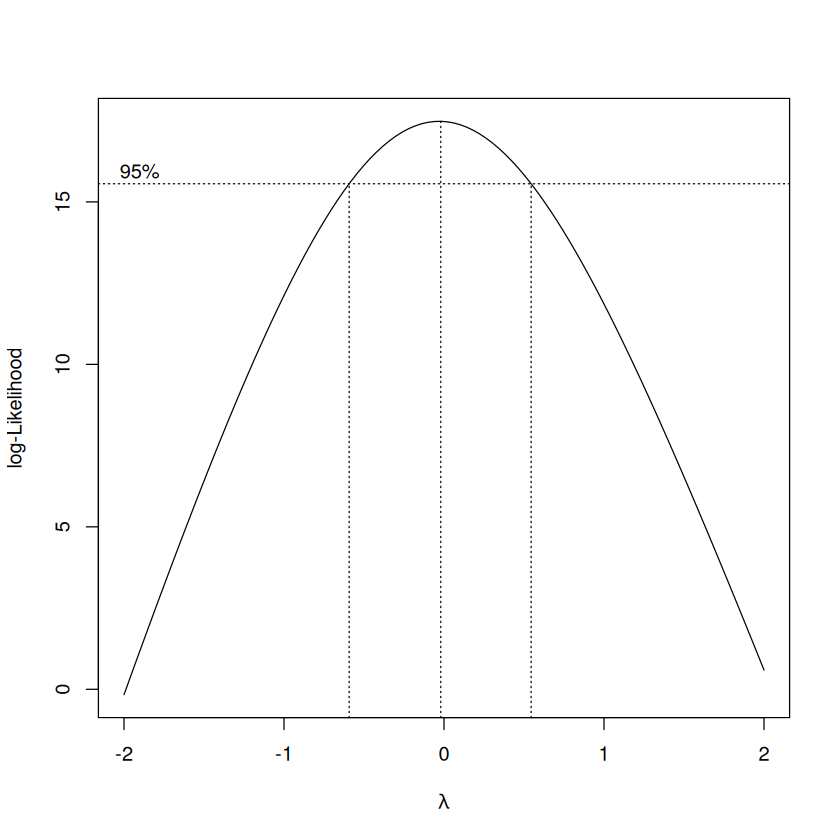

In [3]:
library(MASS)
data(mtcars)
mod <- lm(mpg ~ wt + hp + cyl, data=mtcars)
box <- boxcox(mod)

The plot shows all the values of $\lambda$ that were considered along the $x$-axis and a plot of the log-likelihood along the $y$-axis. We can see that the value that maximises the likelihood is very close to 0, and so we may want to consider a simple log-transformation. If we want to know the precise value of $\hat{\lambda}$ here, we can use

In [4]:
lik      <- box$y
lam      <- box$x 
best.lam <- lam[lik == max(lik)]
print(best.lam)

[1] -0.02020202


We could include this in the regression model by using the formula `I(mpg^best.lam) ~ wt + hp + cy`, however, this is equivalent to the transformation $\frac{1}{\text{MPG}^{0.02}}$, which is not very interpretable. Given that this is very close to $\hat{\lambda} = 0$, we would choose the log-transformation instead. We try this below and create the assumptions plots first for the original mdoel

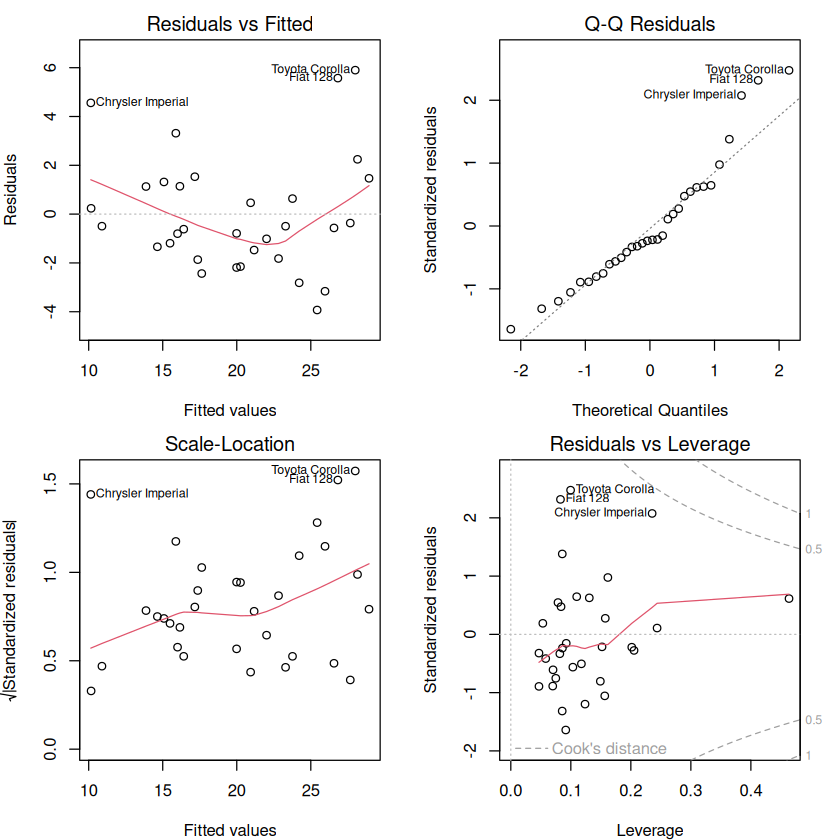

In [5]:
log.mod <- lm(log(mpg) ~ wt + hp + cyl, data=mtcars)
par(mfrow=c(2,2), mar=c(4,4,2,2))
plot(mod)

And then for the log-transformed model

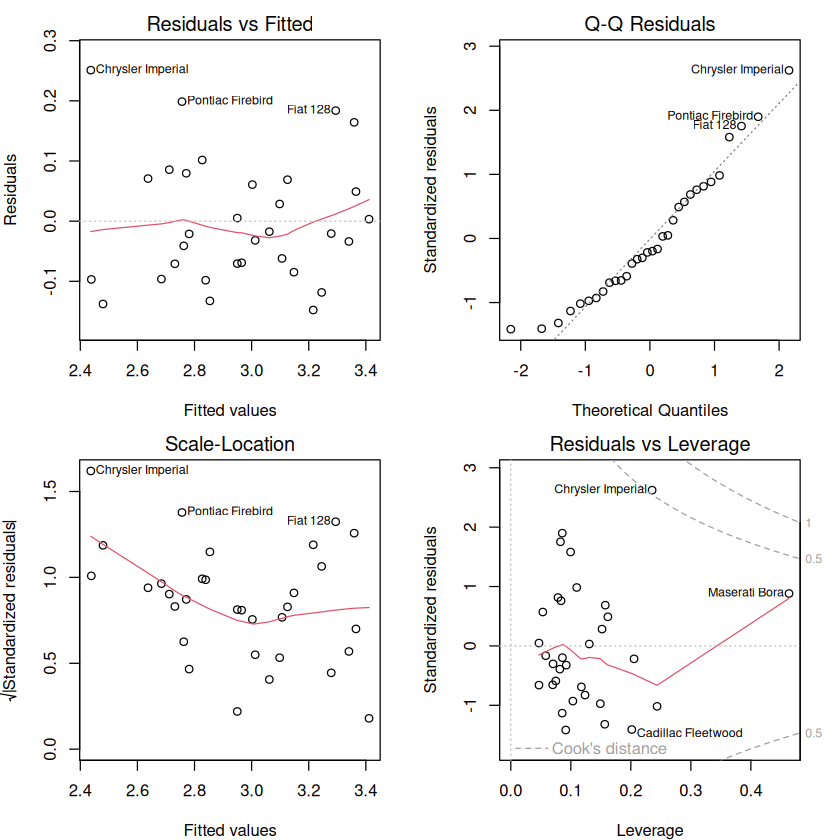

In [6]:
par(mfrow=c(2,2), mar=c(4,4,2,2))
plot(log.mod)

This does seem to have helped, particularly in terms of linearising the relationships in the data and bringing in some of the heavier tails of the residual distribution. We can see this improvement in fit by examining the effects plot for the transformed model.

In [7]:
options(warn=-1)

Loading required package: carData

lattice theme set by effectsTheme()
See ?effectsTheme for details.



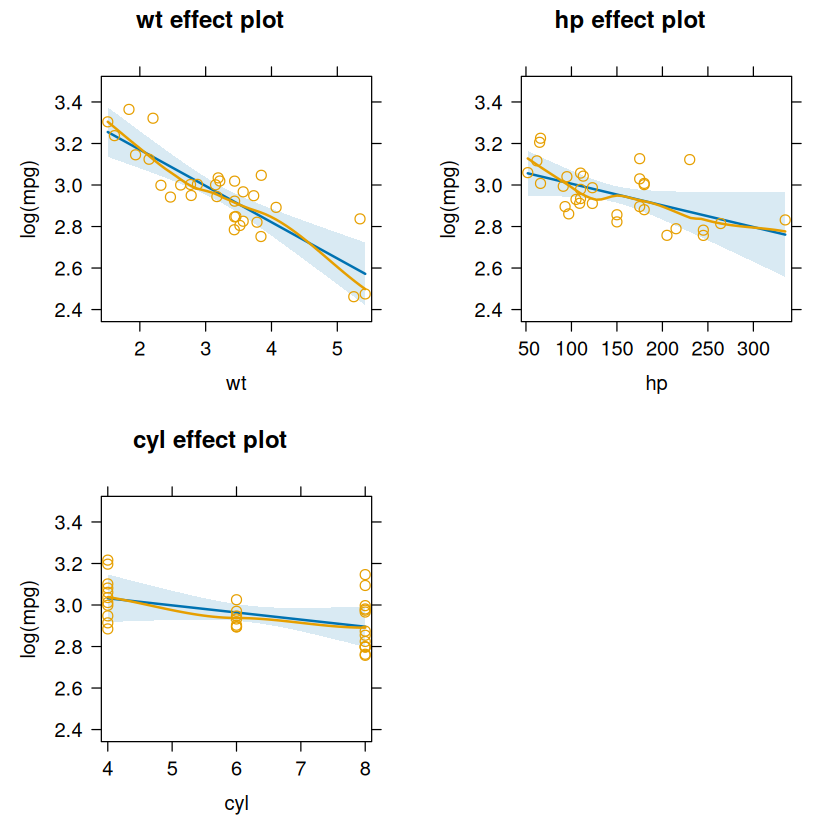

In [8]:
library(effects)
plot(allEffects(log.mod, residuals=TRUE))

Although this seems like a successful application of the Box-Cox method, we always need to take interpretation into account when dealing with transformations. The meaning of the regression coefficients has now changed as they correspond to how much the *log* of the outcome changes for a unit increase in each predictor. This might be quite hard to understand and could be enough to dissuade you from considering any transformations of the outcome, even if the model fit can be improved.

## Transforming the Predictors
As well as the outocme, we can also consider transformations applied to the predictors. Typically, these would be used to either linearise certain relationships in the data, or to model those non-linearities directly. In other words, we can either try and *remove* any curved relationships so that a straight-line will work, or we can alter the regression model so that it *includes* curved relationships in its predictions. We will see examples of both below.

### Linearising Relationships

#### Tukey's Ladder of Powers
... We can use the same logic as Tukey's ladder of powers, but just applied to individual predictors. Indeed, this can actually be *more* useful, given that different predictors may have different curvature to their relationships.

#### Box-Tidwell
... Similar considerations to Box-Cox must be made here as well, as the predictors may be hard to interpret once transformed using $\hat{\lambda}$. As an alternative, you may wish to choose a clearer transformation that is *close* to the value of $\hat{\lambda}$ that has been returned. For example

In [9]:
library(car)
box.t <- boxTidwell(mpg ~ wt + hp, ~ wt + hp, data=mtcars)
print(box.t)

   MLE of lambda Score Statistic (z) Pr(>|z|)   
wt      -0.81692              2.7228 0.006473 **
hp       0.28954              2.3741 0.017592 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

iterations =  17 


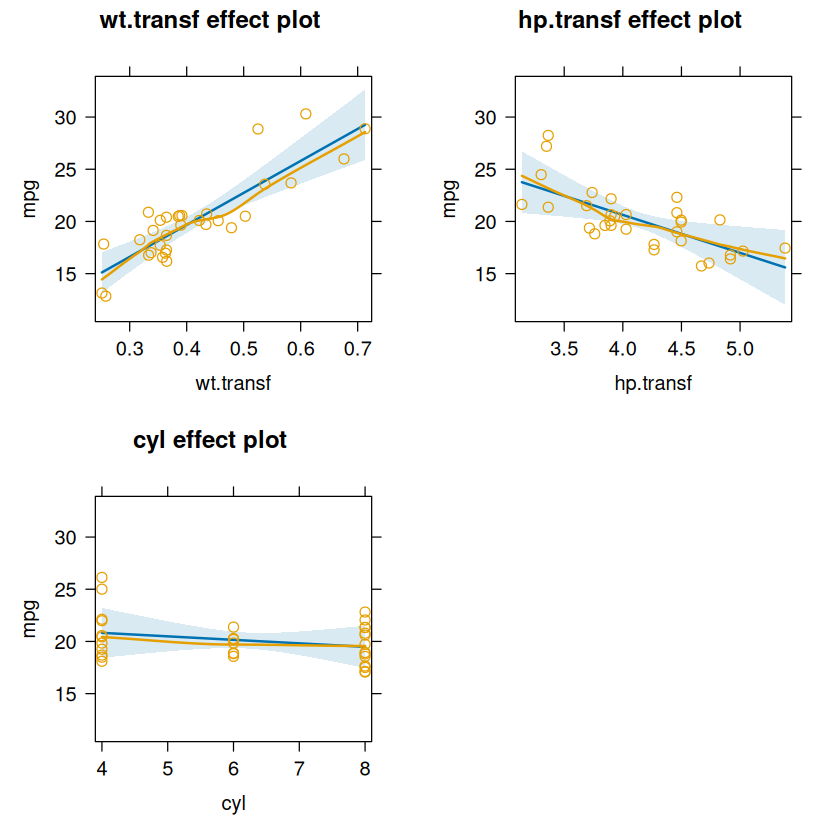

In [10]:
lam       <- c(box.t$result[1], box.t$result[2])
wt.transf <- mtcars$wt^lam[1]
hp.transf <- mtcars$hp^lam[2]
box.t.mod <- lm(mpg ~ wt.transf + hp.transf + cyl, data=mtcars)
plot(allEffects(box.t.mod, residuals=TRUE))

So this had done the job, but what exactly does $\frac{1}{\text{weight}^{0.82}}$ or $\text{horsepower}^{0.29}$ mean? Instead, we can see that $\hat{\lambda}_{1}$ is quite close to $-1$, which would give us $\frac{1}{\text{weight}}$. Similarly, $\hat{\lambda}_{2}$ is quite close to $0.33$, which would give us $\text{weight}^{\frac{1}{3}} = \sqrt[3]{\text{weight}}$. So now we are using the reciprocol of `wt` and the cube-root of `hp`. We can try these and see what happens

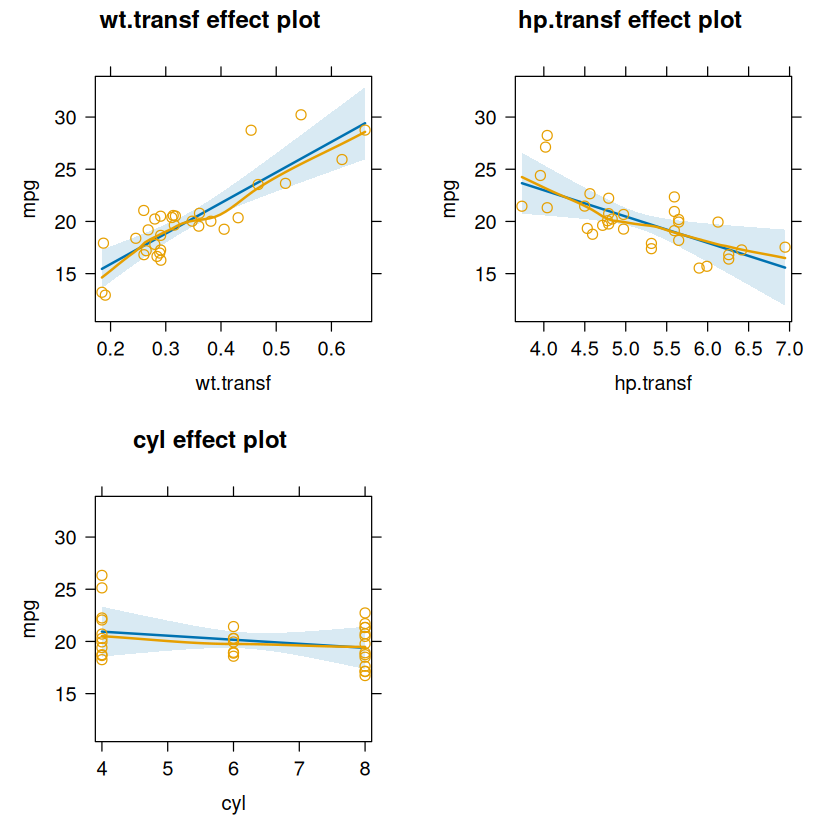

In [11]:
wt.transf  <- 1/mtcars$wt
hp.transf  <- mtcars$hp^(1/3)
transf.mod <- lm(mpg ~ wt.transf + hp.transf + cyl, data=mtcars)
plot(allEffects(transf.mod, residuals=TRUE))

So the fit is very similar, but we have used transformations that are easier to interpret. Nevertheless, it is notable that using the reciprocal flips the largest and smallest values of `wt` and thus the relationship is now reversed. As always, the effect of the transformation on interpretation needs to be taken seriously and could be a reason to choose *not* to do this.

#### Visualising Transforms Further
One of the more useful aspects of the `effects` package is that if the transformation is embedded in the model equation, it will be reverse when the effect is plotted and you can see the shape that is being *removed* from the data, on the original scale.  So, in these examples, think of the plot as showing the curve that is being *removed* in order to linearise the relationship and make a straight-line suitable. In the example below, we stick to the transforms derived from the Box-Tidwell method, but implement them within the model equation (using the `I()` notation) so that the `effects` package is aware of them. When we do this and plot the data, we can effectively see the shape of the relationship implied by the transformation. So these relationships are *linear* on the transformed scale and *non-linear* on their original scale.

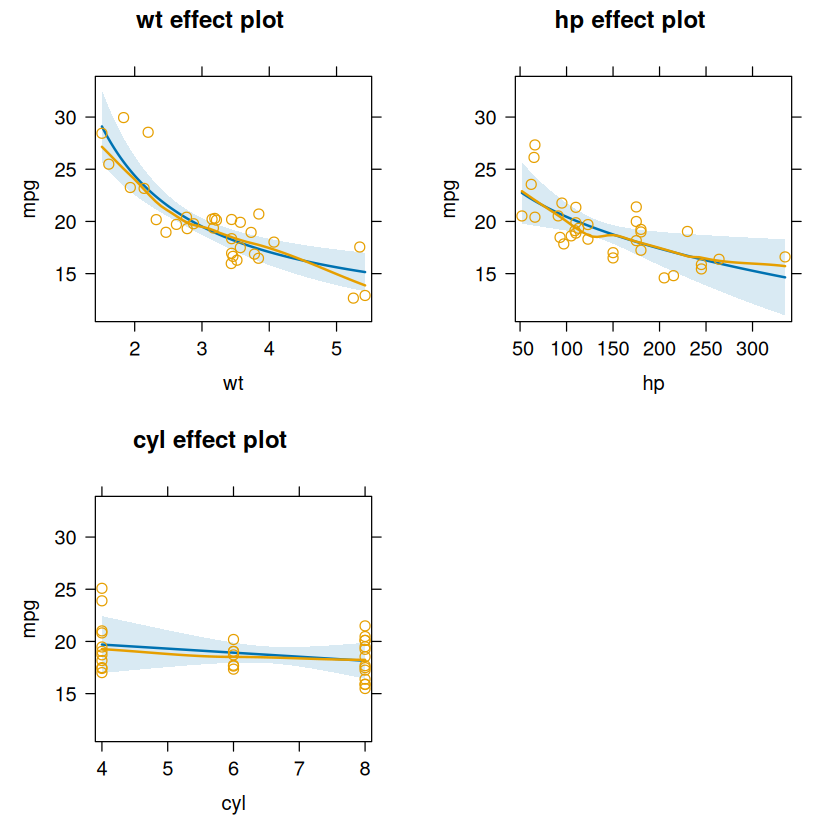

In [12]:
transf.mod <- lm(mpg ~ I(1/wt) + I(hp^(1/3)) + cyl, data=mtcars)
plot(allEffects(transf.mod, residuals=TRUE))

### Polynomial Regression
Although we can see how predictor transforms are able to help meet the assumptions of the regression model, doing so comes with a cost in terms of interpretation. Although we can make a straight-line work by turning $\text{weight} \rightarrow \frac{1}{\text{weight}}$, it might not be very clear what this *means*. Unfortunately, because we have transformed the data, all our inference and interpretation must not be conducted on this transformed scale. Thus, we can end up in a situation where the model fits very well, but we cannot explain any of the results.

An alternative, and often preferable approach, is not to change the predictors to suit the model. Instead, we change the model to suit the predictors. So, rather than trying to *remove* curvature from the data, we could instead *include* curvature in the model. This means that we do not change the predictors, instead we change the model by introducting a *function* of the predictors. The simplest way of doing this is to use a *polynomial* function of each predictor we want to model using a curved relationship.

A polynomial of degree $d$ is a function of a single predictor of the following form

$$
\text{poly}_{d}\left(x_{i}\right) = \beta_{0}x_{i}^{0} + \beta_{1}x_{i}^{1} + \beta_{2}x_{i}^{2} + \cdots + \beta_{d}x_{i}^{d} = \sum_{p=0}^{d} \beta_{p}x_{i}^{p}.
$$

Effectively, we just raise $x_{i}$ to as many powers as we like and then plug them into the regression equation. What does this do? It fits a *curve* to the data, where the number of *bends* in the curve is controlled by the degree $d$. A polynomial of $d=0$ is a constant. A polynomial of $d=1$ is linear and fits a straight-line with $d-1 = 0$ bends. A polynomial of $d=2$ (known as a *quadratic* polynomial) fits a curved line with $d-1 = 1$ bend. A polynomial of $d=3$ (known as a *cubic* polynomial) fits a curved line with $d-1=2$ bends, and so on.

We can include polynomials in `R` using the `poly()` function. Looking at the plots of both `wt` and `hp`, they both look like there is a single bend in the relationship, which would imply a *quadratic* realationship using $d=2$. We can try this in `R` using.

In [13]:
poly.mod <- lm(mpg ~ poly(wt,2) + poly(hp,2) + cyl, data=mtcars)
summary(poly.mod)


Call:
lm(formula = mpg ~ poly(wt, 2) + poly(hp, 2) + cyl, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7956 -1.8425 -0.3851  1.4348  4.5607 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   19.51609    3.61441   5.400 1.17e-05 ***
poly(wt, 2)1 -18.70421    3.75554  -4.980 3.54e-05 ***
poly(wt, 2)2   6.37935    2.36169   2.701  0.01200 *  
poly(hp, 2)1 -13.63792    4.87670  -2.797  0.00959 ** 
poly(hp, 2)2   5.67410    2.93010   1.936  0.06375 .  
cyl            0.09285    0.58083   0.160  0.87422    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.174 on 26 degrees of freedom
Multiple R-squared:  0.8908,	Adjusted R-squared:  0.8698 
F-statistic: 42.43 on 5 and 26 DF,  p-value: 1.077e-11


Notice that the `poly()` function adds extra terms to the regression model in order to capture the assumed shape of the curve. Here, we can think of these as the linear and qudratic *components* of the curve[^poly-foot]. We can also use the `effects` package to again see the shape that has, this time, actually been fit to the data.

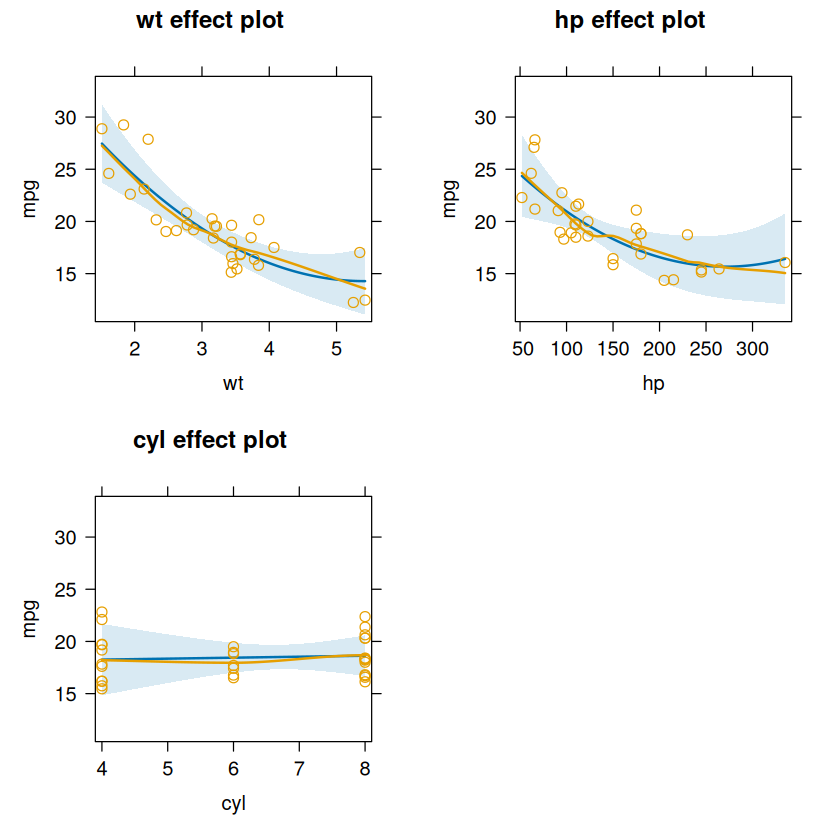

In [14]:
plot(allEffects(poly.mod, residuals=TRUE))

To make it clearer what we are doing, we could also try a higher-degree for `wt`, if we believed that 3 bends would best capture this relationship.


Call:
lm(formula = mpg ~ poly(wt, 3) + poly(hp, 2) + cyl, data = mtcars)

Residuals:
   Min     1Q Median     3Q    Max 
-2.624 -1.450 -0.274  1.062  5.042 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   21.7394     3.9911   5.447 1.18e-05 ***
poly(wt, 3)1 -16.6136     4.0721  -4.080 0.000403 ***
poly(wt, 3)2   5.6993     2.3983   2.376 0.025458 *  
poly(wt, 3)3  -3.1619     2.5224  -1.254 0.221617    
poly(hp, 2)1 -12.7539     4.8753  -2.616 0.014870 *  
poly(hp, 2)2   5.3497     2.9100   1.838 0.077913 .  
cyl           -0.2665     0.6421  -0.415 0.681683    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.151 on 25 degrees of freedom
Multiple R-squared:  0.8973,	Adjusted R-squared:  0.8726 
F-statistic:  36.4 on 6 and 25 DF,  p-value: 3.54e-11


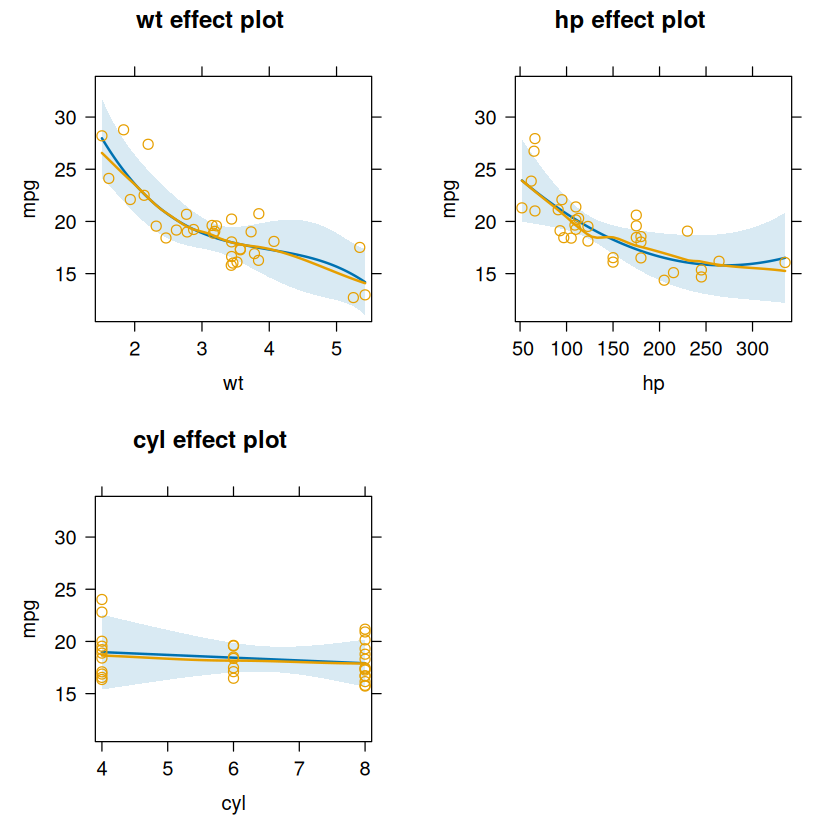

In [17]:
poly.mod <- lm(mpg ~ poly(wt,3) + poly(hp,2) + cyl, data=mtcars)
summary(poly.mod)
plot(allEffects(poly.mod, residuals=TRUE))

There is now an extra wiggle in the fitted relationship between `wt` and `mpg`, governed by the additional model term. However, we can see that this component is not significant and thus may not be adding anything useful to the model. This would appear to be supported by the visualisation from the `effects` package. In general, we would not recommend fitting shapes with $d > 4$, simply to keep the models simpler, keep interpretation more straight-forward and to reduce the risk of the shape being governed more by the noise in the data.

## Standardised Regression

## What if Nothing Works?
These include models for outliers (*robust regression*), heteroscedasticity (*generalised least squares*), multicollinearity (*ridge regression*) and non-normality (*non-parametric resampling*).

[^poly-foot]: This is only because the `poly()` function constructs what are known as *orthogonal* polynomials. This will not be the same as fitting a model using `mpg ~ wt + I(wt^2) + hp + I(hp^2) + cyl`.